In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import calendar

In [2]:
conn = psycopg2.connect(
    host='shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com',
    port='5432',
    user='softtouchlenses_4e0b7c925f8444429457581f35678aea',
    password='softtouchlenses_4e0b7c925f8444429457581f35678aea_password',
    database='softtouchlenses_4e0b7c925f8444429457581f35678aea_db'
)

In [3]:
query1 = """select orders.id as order_id,
created_at::date as order_date,
customer_id as user_id,
order_line_item.product_id as product_id,
order_line_item.name as product_name,
order_line_item.quantity as quantity,
(order_line_item.price - order_line_item.total_discount) as sp
from orders
join order_line_item on orders.id  = order_line_item.order_id
where cancelled_at is NULL;"""

In [4]:
data = pd.read_sql(query1, conn)

<ipython-input-4-0600e2216395>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query1, conn)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2692 entries, 0 to 2691
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   order_id      2692 non-null   int64  
 1   order_date    2692 non-null   object 
 2   user_id       2692 non-null   int64  
 3   product_id    2655 non-null   float64
 4   product_name  2692 non-null   object 
 5   quantity      2692 non-null   int64  
 6   sp            2692 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 147.3+ KB


In [6]:
data.order_date

0       2023-04-30
1       2023-04-26
2       2023-11-25
3       2023-11-25
4       2023-11-24
           ...    
2687    2023-12-01
2688    2023-12-01
2689    2023-12-01
2690    2023-11-30
2691    2023-11-15
Name: order_date, Length: 2692, dtype: object

In [7]:
data

,order_id,order_date,user_id,product_id,product_name,quantity,sp
0,4936354201774,2023-04-30,6422710747310,7.726612e+12,Blue Block Computer Glasses with anti-reflecti...,1,1299.0
1,4931918528686,2023-04-26,6376003436718,7.270624e+12,Aspire Pro Monthly Disposable Contact Lens Coo...,2,1300.0
2,5197214744750,2023-11-25,6729164030126,7.290667e+12,Polylite Monthly Color Disposable Contact Lens...,1,650.0
3,5197214744750,2023-11-25,6729164030126,7.290667e+12,Polylite Monthly Color Disposable Contact Lens...,1,650.0
4,5195141972142,2023-11-24,6727545618606,7.249161e+12,Power Swimming Goggles FEIKE Rx Prescription O...,1,1399.0
...,...,...,...,...,...,...,...
2687,5209560383662,2023-12-01,6425136398510,7.254307e+12,Freshlook ColorBlends Gemstone Green ( 2 pcs i...,1,890.0
2688,5209277989038,2023-12-01,6524375728302,7.289896e+12,ACME 55 ASPHERIC Monthly Contact Lenses ( 6pcs...,1,740.0
2689,5209273335982,2023-12-01,6524375728302,7.289896e+12,ACME 55 ASPHERIC Monthly Contact Lenses ( 6pcs...,1,740.0
2690,5208115544238,2023-11-30,6741484503214,7.994956e+12,MyDay Daily Disposable Contact Lenses COOPERVI...,1,2190.0


In [8]:
#New/Repeat Tag
orderuserlevel=data.groupby(['order_id','user_id']).agg(
          order_date=pd.NamedAgg(column='order_date', aggfunc='min'),

    ).reset_index()
orderuserlevel=orderuserlevel.sort_values('order_date')
orderuserlevel['TrxnRank'] = orderuserlevel.groupby('user_id')['order_date'].rank(method='first')
orderuserlevel


data=pd.merge(data,
         orderuserlevel[['order_id','TrxnRank']],
         on="order_id",
         how ='left')
data['New']=0
data['Repeat']=0
data.loc[data['TrxnRank']==1,'New']=1
data.loc[data['TrxnRank']>1,'Repeat']=1

#AOV Contribution
data['ordervalue']=data['quantity']*data['sp']
data['AOVContribution']=data['ordervalue']/data["order_id"].nunique()

In [9]:
totalcarts=data['order_id'].nunique()
productlevel=data.groupby(['product_id','product_name']).agg(
          Carts=pd.NamedAgg(column='order_id', aggfunc='nunique'),
     Quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
          ASP=pd.NamedAgg(column='sp', aggfunc='mean'),
          NewOrders=pd.NamedAgg(column='New', aggfunc='sum'),
          RepeatOrders=pd.NamedAgg(column='Repeat', aggfunc='sum'),
          Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
          AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
    ).reset_index()
productlevel['CartPenetration']=productlevel['Carts']/totalcarts
productlevel['NewUserRatio']=productlevel['NewOrders']/productlevel['Users']
productlevel['QpC']=productlevel['Quantity']/productlevel['Carts']
productlevel['ASPXQpC']=productlevel['ASP']*productlevel['QpC']

In [10]:
productlevel.sort_values('CartPenetration', ascending=False).head(50)

,product_id,product_name,Carts,Quantity,ASP,NewOrders,RepeatOrders,Users,AOVContribution,CartPenetration,NewUserRatio,QpC,ASPXQpC
578,7.283010e+12,Prosthetic Contact lenses Dark Brown Polylite 38,123,134,1000.000000,91,32,101,58.413252,0.053618,0.900990,1.089431,1089.430894
580,7.283065e+12,Prosthetic Contact lenses Medium Brown Polylit...,110,111,1000.000000,75,35,88,48.387097,0.047951,0.852273,1.009091,1009.090909
574,7.280473e+12,Aspire Pro Torics Monthly Disposable Contact L...,92,173,1353.591837,95,52,60,102.583697,0.040105,1.583333,1.880435,2545.341171
579,7.283062e+12,Prosthetic Contact lenses Light Brown Polylite 38,69,76,1000.000000,33,36,44,33.129904,0.030078,0.750000,1.101449,1101.449275
575,7.282565e+12,Red Filter X- Chrome Silver Line Laboratories ...,43,49,2200.000000,35,8,37,46.992153,0.018745,0.945946,1.139535,2506.976744
47,7.249161e+12,Power Swimming Goggles FEIKE Rx Prescription O...,32,32,1399.000000,29,3,30,19.515257,0.013949,0.966667,1.000000,1399.000000
50,7.249161e+12,Power Swimming Goggles FEIKE Rx Prescription O...,32,32,1399.000000,29,3,32,19.515257,0.013949,0.906250,1.000000,1399.000000
52,7.249161e+12,Power Swimming Goggles FEIKE Rx Prescription O...,29,29,1399.000000,28,1,29,17.685702,0.012642,0.965517,1.000000,1399.000000
46,7.249161e+12,Power Swimming Goggles FEIKE Rx Prescription O...,28,28,1399.000000,26,2,27,17.075850,0.012206,0.962963,1.000000,1399.000000
53,7.249161e+12,Power Swimming Goggles FEIKE Rx Prescription O...,26,27,1399.000000,23,3,24,16.465998,0.011334,0.958333,1.038462,1452.807692


In [11]:
CP_labels, NewRatio_labels,ASP_labels, QpC_labels =  range(1,5), range(1,5),range(1,5),range(1,5)

productlevel['CP_score'] = productlevel['CartPenetration'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = CP_labels)).astype('int64')
productlevel['NewRatio_score'] = productlevel['NewUserRatio'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = NewRatio_labels)).astype('int64')
productlevel['ASP_score'] = productlevel['ASP'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = ASP_labels)).astype('int64')
productlevel['QpC_score'] = productlevel['QpC'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = QpC_labels)).astype('int64')
productlevel['SumScore'] = productlevel['CP_score'] + productlevel['NewRatio_score'] + productlevel['ASP_score'] + productlevel['QpC_score']


In [12]:
def ProductCohortLables(df):
    if df['SumScore'] > 15:
        return 'Hero Products'
    elif ((df['CP_score'] >3) and (df['SumScore'] >= 8)and (df['SumScore'] <= 15) and (df['NewRatio_score'] >3)):
        return 'Marquee & New Business Drivers'
    elif ((df['CP_score'] >3) and (df['SumScore'] >= 8)and (df['SumScore'] <= 15)and (df['NewRatio_score'] <=3)):
        return 'Marquee & Repeat Business Drivers'

    elif ((df['ASP_score'] >3) and (df['SumScore'] >= 5)and (df['SumScore'] < 8)and (df['QpC_score'] <=3)):
        return 'High Value & Slow Moving'
    elif ((df['ASP_score'] <=3) and (df['SumScore'] >= 5)and (df['SumScore'] < 8)and (df['QpC_score'] >3)):
        return 'Low Value & Slow Moving'
    else:
        return 'Lagging Products'

In [13]:
productlevel['Product Cohort Lables'] = productlevel.apply(ProductCohortLables, axis=1)


In [14]:
productlevel['Product Cohort Lables'].value_counts()

Lagging Products                     602
Marquee & Repeat Business Drivers    150
Marquee & New Business Drivers        36
Hero Products                         14
High Value & Slow Moving               4
Low Value & Slow Moving                2
Name: Product Cohort Lables, dtype: int64

In [15]:
productlevel

,product_id,product_name,Carts,Quantity,ASP,NewOrders,RepeatOrders,Users,AOVContribution,CartPenetration,NewUserRatio,QpC,ASPXQpC,CP_score,NewRatio_score,ASP_score,QpC_score,SumScore,Product Cohort Lables
0,7.246198e+12,Affaires Blue Ray Block glasses Frames for Kid...,1,1,845.0,1,0,1,0.368352,0.000436,1.000000,1.0,845.0,1,1,2,1,5,Lagging Products
1,7.246404e+12,Affaires Blue Ray Block glasses Frames for Kid...,2,2,845.0,2,0,2,0.736704,0.000872,1.000000,1.0,845.0,3,1,2,1,7,Lagging Products
2,7.246415e+12,Affaires Blue Ray Block glasses Frames for Kid...,14,14,845.0,13,1,14,5.156931,0.006103,0.928571,1.0,845.0,4,1,2,1,8,Marquee & Repeat Business Drivers
3,7.246426e+12,Affaires Blue Ray Block glasses Frames for Kid...,2,2,845.0,2,0,2,0.736704,0.000872,1.000000,1.0,845.0,3,1,2,1,7,Lagging Products
4,7.246429e+12,Affaires Blue Ray Block glasses Frames for Kid...,4,4,845.0,3,1,3,1.473409,0.001744,1.000000,1.0,845.0,4,1,2,1,8,Marquee & Repeat Business Drivers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,8.091588e+12,Freshlook Circle Color Allure Hazel - Daily Di...,1,1,1394.0,0,1,1,0.607672,0.000436,0.000000,1.0,1394.0,3,1,3,4,11,Lagging Products
804,8.099733e+12,Air Optix plus HydraGlyde Monthly Disposable A...,1,1,1154.0,1,0,1,0.503051,0.000436,1.000000,1.0,1154.0,3,4,3,4,14,Lagging Products
805,8.099733e+12,Air Optix plus HydraGlyde Monthly Disposable A...,1,2,1154.0,1,0,1,1.006103,0.000436,1.000000,2.0,2308.0,3,4,3,4,14,Lagging Products
806,8.099733e+12,Air Optix plus HydraGlyde Monthly Disposable A...,1,1,1154.0,1,0,1,0.503051,0.000436,1.000000,1.0,1154.0,3,4,3,4,14,Lagging Products


In [16]:
segstats=productlevel.groupby(
   'Product Cohort Lables'
).agg(
       ProductCount=pd.NamedAgg(column='product_id', aggfunc='nunique'),
       Orders=pd.NamedAgg(column='Carts', aggfunc='sum'),
       Users=pd.NamedAgg(column='Users', aggfunc='sum'),
       AverageSellingPrice=pd.NamedAgg(column='ASP', aggfunc='mean'),
       QuantityperCart=pd.NamedAgg(column='QpC', aggfunc='mean'),
       CartPenetration  =pd.NamedAgg(column='CartPenetration', aggfunc='mean'),
       NewUserRatio=pd.NamedAgg(column='NewUserRatio', aggfunc='mean'),
      NewOrders=pd.NamedAgg(column='NewOrders', aggfunc='sum'),
       ASPXQpC=pd.NamedAgg(column='ASPXQpC', aggfunc='sum'),
       AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
       Top10SKUs=pd.NamedAgg(column='product_name', aggfunc=lambda x: x.value_counts().index[:10]),
      Bottom10SKUs=pd.NamedAgg(column='product_name', aggfunc=lambda x: x.value_counts().index[-10:-1])

 ).reset_index()
segstats=segstats.sort_values('CartPenetration', ascending =False)
segstats
segstats['ProductCountMix']=segstats['ProductCount']/segstats['ProductCount'].sum()
segstats['OrdersMix']=segstats['Orders']/segstats['Orders'].sum()
segstats['UsersMix']=segstats['Users']/segstats['Users'].sum()
segstats['AOVContribution(%)']=segstats['AOVContribution']/segstats['AOVContribution'].sum()
segstats['OrderPerSKU']=segstats['Orders']/segstats['ProductCount']

In [17]:
segstats.columns

Index(['Product Cohort Lables', 'ProductCount', 'Orders', 'Users',
       'AverageSellingPrice', 'QuantityperCart', 'CartPenetration',
       'NewUserRatio', 'NewOrders', 'ASPXQpC', 'AOVContribution', 'Top10SKUs',
       'Bottom10SKUs', 'ProductCountMix', 'OrdersMix', 'UsersMix',
       'AOVContribution(%)', 'OrderPerSKU'],
      dtype='object')

In [18]:
SummaryTable=segstats[['Product Cohort Lables', 'ProductCount','OrdersMix',
       'UsersMix','AverageSellingPrice',
       'CartPenetration',"QuantityperCart",'NewUserRatio','AOVContribution',
       'Top10SKUs', 'Bottom10SKUs','OrderPerSKU', ]]


In [19]:
SummaryTable.to_csv('st.csv')
#productlevel.to_csv('pl.csv')

In [20]:
SummaryTable


,Product Cohort Lables,ProductCount,OrdersMix,UsersMix,AverageSellingPrice,CartPenetration,QuantityperCart,NewUserRatio,AOVContribution,Top10SKUs,Bottom10SKUs,OrderPerSKU
5,Marquee & Repeat Business Drivers,43,0.576863,0.552156,1317.247154,0.004275,1.175162,0.899958,962.858326,[Affaires Blue Ray Block glasses Frames for Ki...,[Affaires Color Yearly Contact Lenses One Tone...,34.209302
0,Hero Products,11,0.043529,0.035234,2420.227831,0.003456,1.808421,1.146939,191.848736,"[Soflens Toric Bausch & Lomb (6 Lens Per Box),...",[Dailies Total 1 Contact Lenses ALCON Ciba Vis...,10.090909
4,Marquee & New Business Drivers,16,0.089804,0.086694,1025.971378,0.002773,1.072274,1.024140,172.391020,[Aspire Pro Torics Monthly Disposable Contact ...,[Affaires Rimless Flexible Lightweight Reading...,14.312500
2,Lagging Products,164,0.287451,0.323134,1068.320598,0.000531,1.155316,0.858306,410.781604,[Affaires Blue Ray Block glasses Frames for Ki...,[Bausch & Lomb BioTrue One Day Disposable Lens...,4.469512
1,High Value & Slow Moving,1,0.001569,0.001854,1399.000000,0.000436,1.000000,1.000000,2.439407,[Power Swimming Goggles FEIKE Rx Prescription ...,[Power Swimming Goggles FEIKE Rx Prescription ...,4.000000
3,Low Value & Slow Moving,2,0.000784,0.000927,371.500000,0.000436,2.500000,1.000000,0.734525,[Affaires fashionable Sunglasses Eyeglasses Ca...,Affaires fashionable Sunglasses Eyeglasses Cas...,1.000000


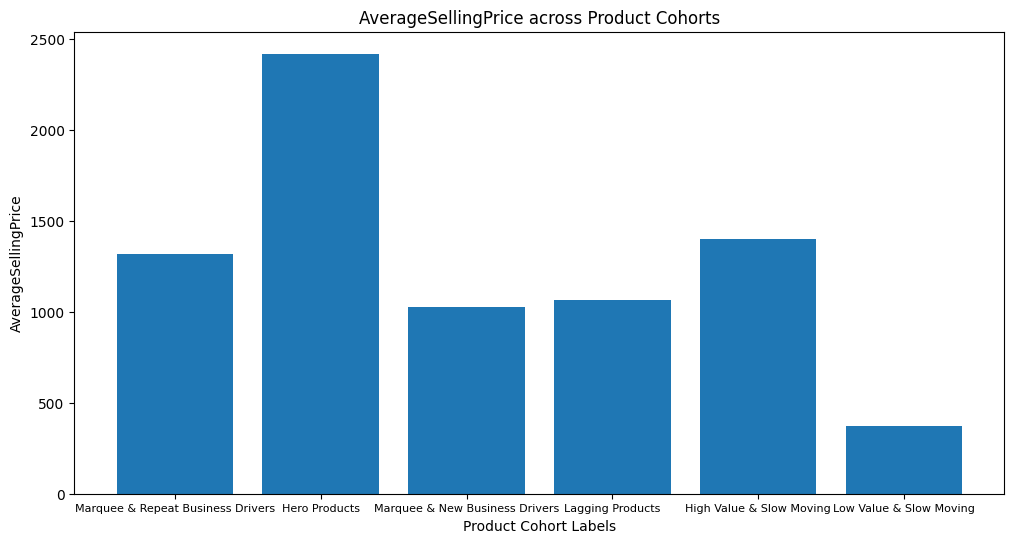

In [21]:
column_to_plot = 'AverageSellingPrice'
x_labels = SummaryTable['Product Cohort Lables']
plt.figure(figsize=(12, 6))  # Adjust the figure size if needed
plt.bar(x_labels, SummaryTable[column_to_plot])
plt.xlabel('Product Cohort Labels')
plt.ylabel(column_to_plot)
plt.title(f'{column_to_plot} across Product Cohorts')
plt.xticks(fontsize=8)
plt.show()

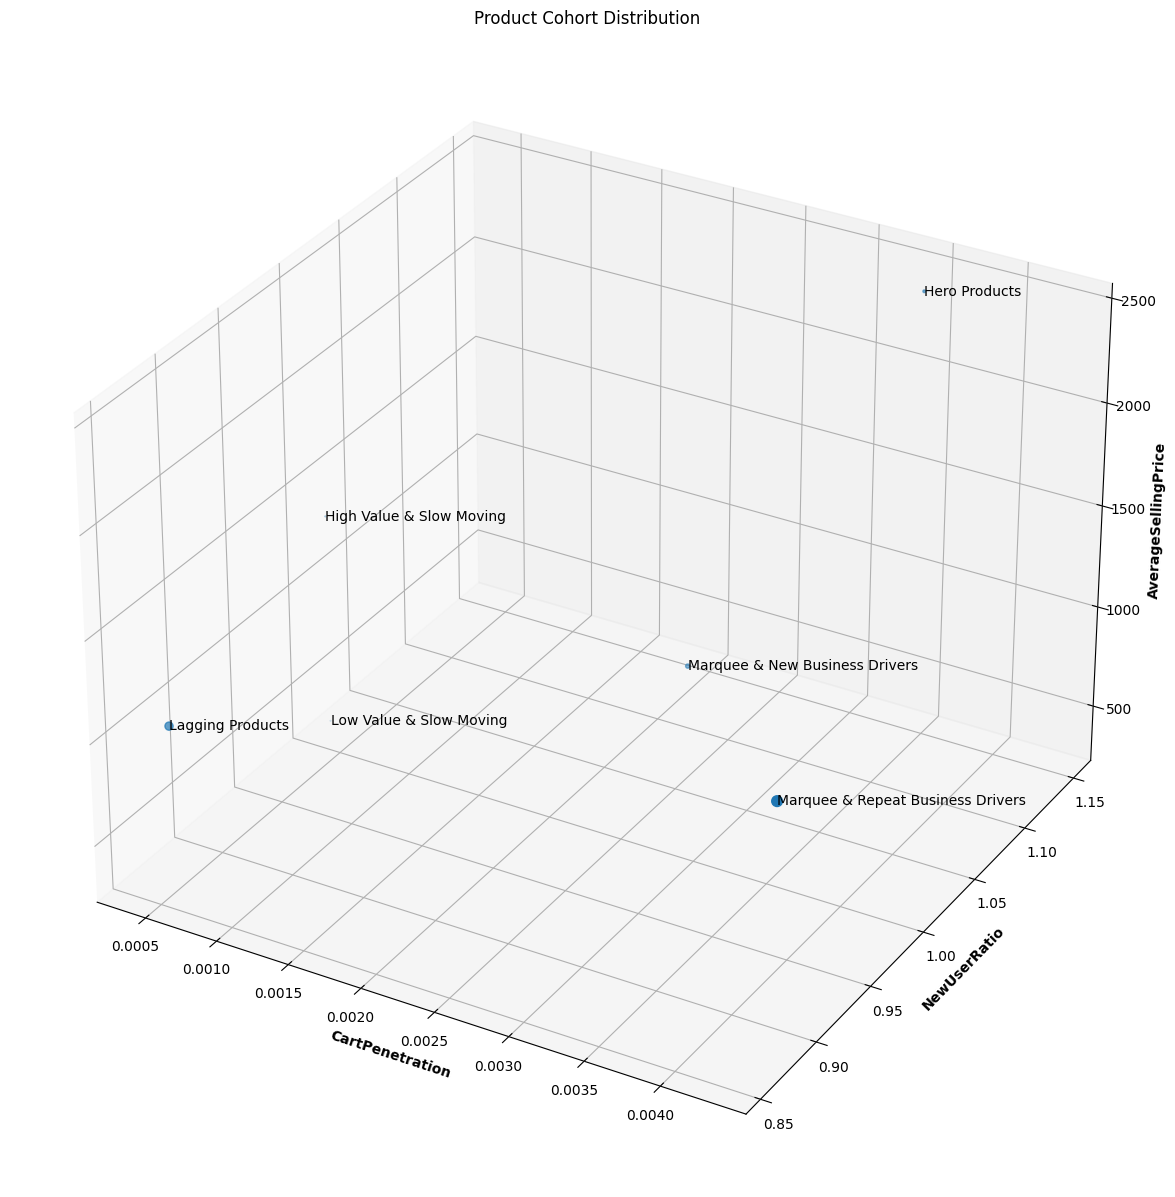

In [22]:
#Visualization of cohorts with key parameters as axises
fig = plt.figure(figsize = (15, 15))
ax = plt.axes(projection ="3d")
size=segstats['Users']*.05
# Creating plot
ax.scatter3D(segstats['CartPenetration'], segstats['NewUserRatio'],segstats['AverageSellingPrice'], s=size)
plt.title("Product Cohort Distribution")
ax.set_xlabel('CartPenetration', fontweight ='bold')
ax.set_ylabel('NewUserRatio', fontweight ='bold')
ax.set_zlabel('AverageSellingPrice', fontweight ='bold')
for i in range(len(segstats)):
     ax.text(segstats['CartPenetration'][i],
               segstats['NewUserRatio'][i],
             segstats['AverageSellingPrice'][i],
               segstats['Product Cohort Lables'][i],
               horizontalalignment='left',
               rotation=25, wrap=True,
               verticalalignment='center',
               size='medium', color='black')
